# GPOSをtimestamp,x,y,zの形にする仮プログラム

In [10]:
import pandas as pd
import os

# 入力ファイルのパス
input_path = "02_realtime_sample/output/gpos.csv"

# 出力ファイルのディレクトリとファイル名フォーマット
output_dir = "02_realtime_sample/output"
output_template = "gpos_{}.csv"

# CSV読み込み
df = pd.read_csv(input_path)

# 必要なカラムだけ抽出
df_extracted = df[["app_timestamp", "object_id", "location_x", "location_y", "location_z"]]
df_extracted = df_extracted.rename(columns={
    "app_timestamp": "timestamp",
    "location_x": "x",
    "location_y": "y",
    "location_z": "z"
})

# object_idごとにファイルを分けて保存
for object_id, group in df_extracted.groupby("object_id"):
    output_path = os.path.join(output_dir, output_template.format(object_id))
    group[["timestamp", "x", "y", "z"]].to_csv(output_path, index=False)
    print(f"Saved: {output_path}")


Saved: 02_realtime_sample/output/gpos_3583WAA.csv
Saved: 02_realtime_sample/output/gpos_3636DWF.csv
Saved: 02_realtime_sample/output/gpos_3637RLJ.csv


# timestamp,x,y,zの形で入っているCSVをプロットする
# ===インポート===

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

# === 設定 ===

In [12]:
map_filename = "map/miraikan_5.bmp"
csv_files = ["02_realtime_sample/output/gpos_3583WAA.csv"]
map_origin = (-5.625, -12.75)
map_ppm = 100  # pixels per meter
decimation_rate = 50  # 矢印の間引き率

# === マップ読み込み ===

In [13]:
def load_map_image(path):
    return np.array(Image.open(path)) / 255.0

# === 地図描画関数 ===

In [14]:
def plot_map(ax, bitmap, map_origin, map_ppm):
    height, width = bitmap.shape[:2]
    extent = [
        map_origin[0], map_origin[0] + width / map_ppm,
        map_origin[1], map_origin[1] + height / map_ppm
    ]
    ax.imshow(bitmap, extent=extent, alpha=0.5, cmap='gray')

# === クォータニオン → ヨー角変換 ===

In [15]:
def quaternion_to_yaw(qw, qx, qy, qz):
    return np.arctan2(2.0 * (qw * qz + qx * qy), 1.0 - 2.0 * (qy * qy + qz * qz))


# === ヨー角のベクトルを描画 ===

In [16]:
def plot_yaw(ax, df, decimation_rate=1):
    if "yaw" not in df.columns:
        return
    decimated_df = df.iloc[::decimation_rate]
    arrow_length = 1.5
    dx = arrow_length * np.cos(decimated_df.yaw)
    dy = arrow_length * np.sin(decimated_df.yaw)

    ax.quiver(decimated_df.x, decimated_df.y, dx, dy,
              angles='xy', scale_units='xy', scale=1,
              color='red', alpha=0.7, width=0.003,
              label="yaw direction")

# === メイン処理 ===

プロット中: 02_realtime_sample/output/gpos_3583WAA.csv


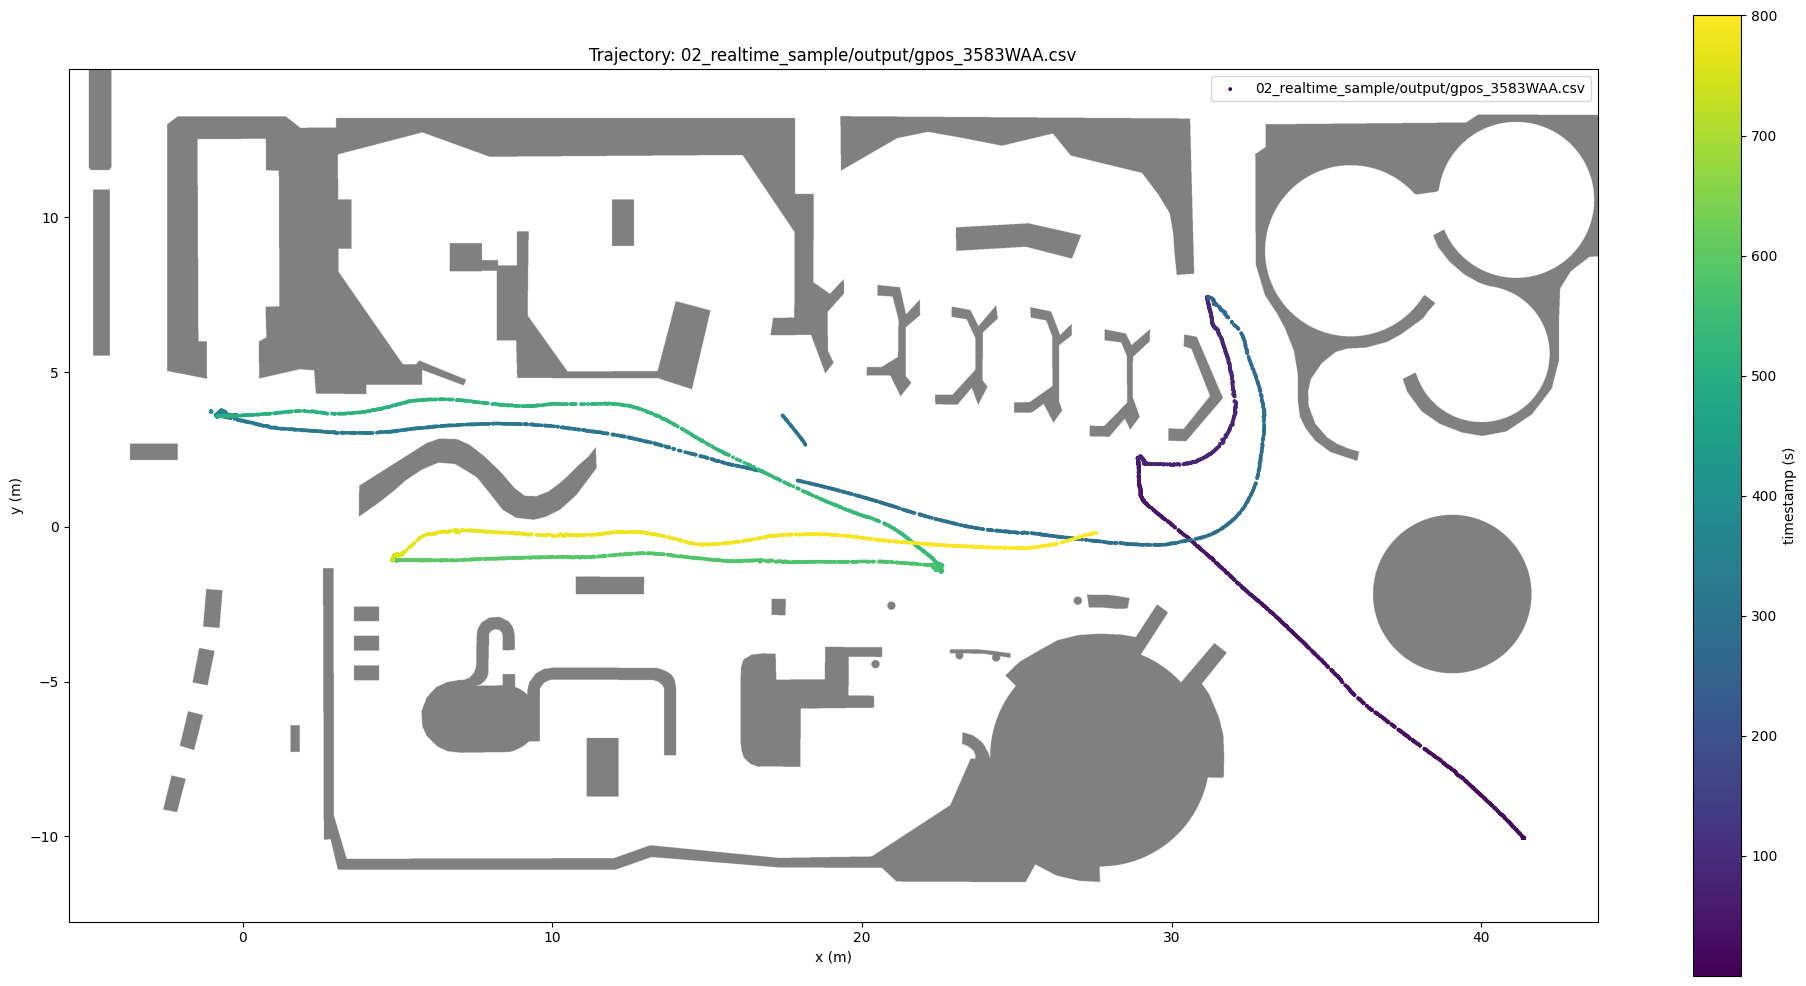

In [17]:
def main():
    # マップ読み込み
    map_img = load_map_image(map_filename)

    if not csv_files:
        print("CSVファイルが見つかりません。")
        return

    for csv_file in csv_files:
        print(f"プロット中: {csv_file}")
        try:
            df = pd.read_csv(csv_file)

            if {'x', 'y', 'timestamp'}.issubset(df.columns):
                pass
            else:
                print(f"スキップ: {csv_file} に必要なカラムがありません。")
                continue

            # クォータニオンがある場合はヨー角に変換
            if {'qw', 'qx', 'qy', 'qz'}.issubset(df.columns):
                df['yaw'] = quaternion_to_yaw(df.qw, df.qx, df.qy, df.qz)

            # 描画
            fig, ax = plt.subplots(1, 1, figsize=(20, 10))
            plot_map(ax, map_img, map_origin, map_ppm)

            scatter = ax.scatter(df.x, df.y, c=df.timestamp, s=3, cmap='viridis', label=csv_file)
            plot_yaw(ax, df, decimation_rate=decimation_rate)

            ax.set_xlabel("x (m)")
            ax.set_ylabel("y (m)")
            plt.colorbar(scatter, ax=ax, label='timestamp (s)')
            plt.legend()
            plt.title(f"Trajectory: {csv_file}")
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"エラーが発生しました: {csv_file}, {e}")

if __name__ == "__main__":
    main()